# **Facial Expression Recognition**

**This Notebook releate to build a CNN model to acurately categorize 7 type of human facial expression
which are [sad, happy, disgust, angry, neutral, fear, surprise]**


In [1]:
from IPython.display import clear_output
!pip install tf_explain
! pip install segmentation-models
clear_output()
from tf_explain.core.grad_cam import GradCAM

**Importing Modules**

In [2]:
#!pip install git+git://github.com/stared/livelossplot.git
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
%matplotlib inline

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Flatten, Dense, Reshape, Multiply, Add,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import tensorflow as tf
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
# from livelossplot import PlotLossesTensorFlowKeras
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.6.4


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

**Load and Explore the Dataset**

In [5]:
data_path = '/kaggle/input/ckplus/CK+48'
data_dir_list = os.listdir(data_path)

img_rows, img_cols = 48, 48
num_classes = 7
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-surprise

Loaded the images of dataset-fear

Loaded the images of dataset-sadness

Loaded the images of dataset-disgust

Loaded the images of dataset-contempt

Loaded the images of dataset-happy

Loaded the images of dataset-anger



(981, 48, 48, 3)

In [6]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:248]=0 #249
labels[249:323]=1 #75
labels[324:407]=2 #84
labels[408:584]=3 #177
labels[585:638]=4 #54
labels[639:845]=5 #207
labels[846:980]=6 #135

names = ['surprise','fear','sadness','disgust' ,'contempt','happy','anger']

def getLabel(id):
    return ['surprise','fear','sadness','disgust' ,'contempt','happy','anger'][id]

In [7]:
from keras.utils import np_utils
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)
x_test=X_test

**Augmentation and Preprocessing**

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
import numpy as np


class StandardizedConv2DWithOverride(layers.Conv2D):
    def convolution_op(self, inputs, kernel):
        mean, var = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
        return tf.nn.conv2d(
            inputs,
            (kernel - mean) / tf.sqrt(var + 1e-10),
            padding="VALID",
            strides=list(self.strides),
            name=self.__class__.__name__,
        )
# Inputs
input_layer = Input((48,48,3))

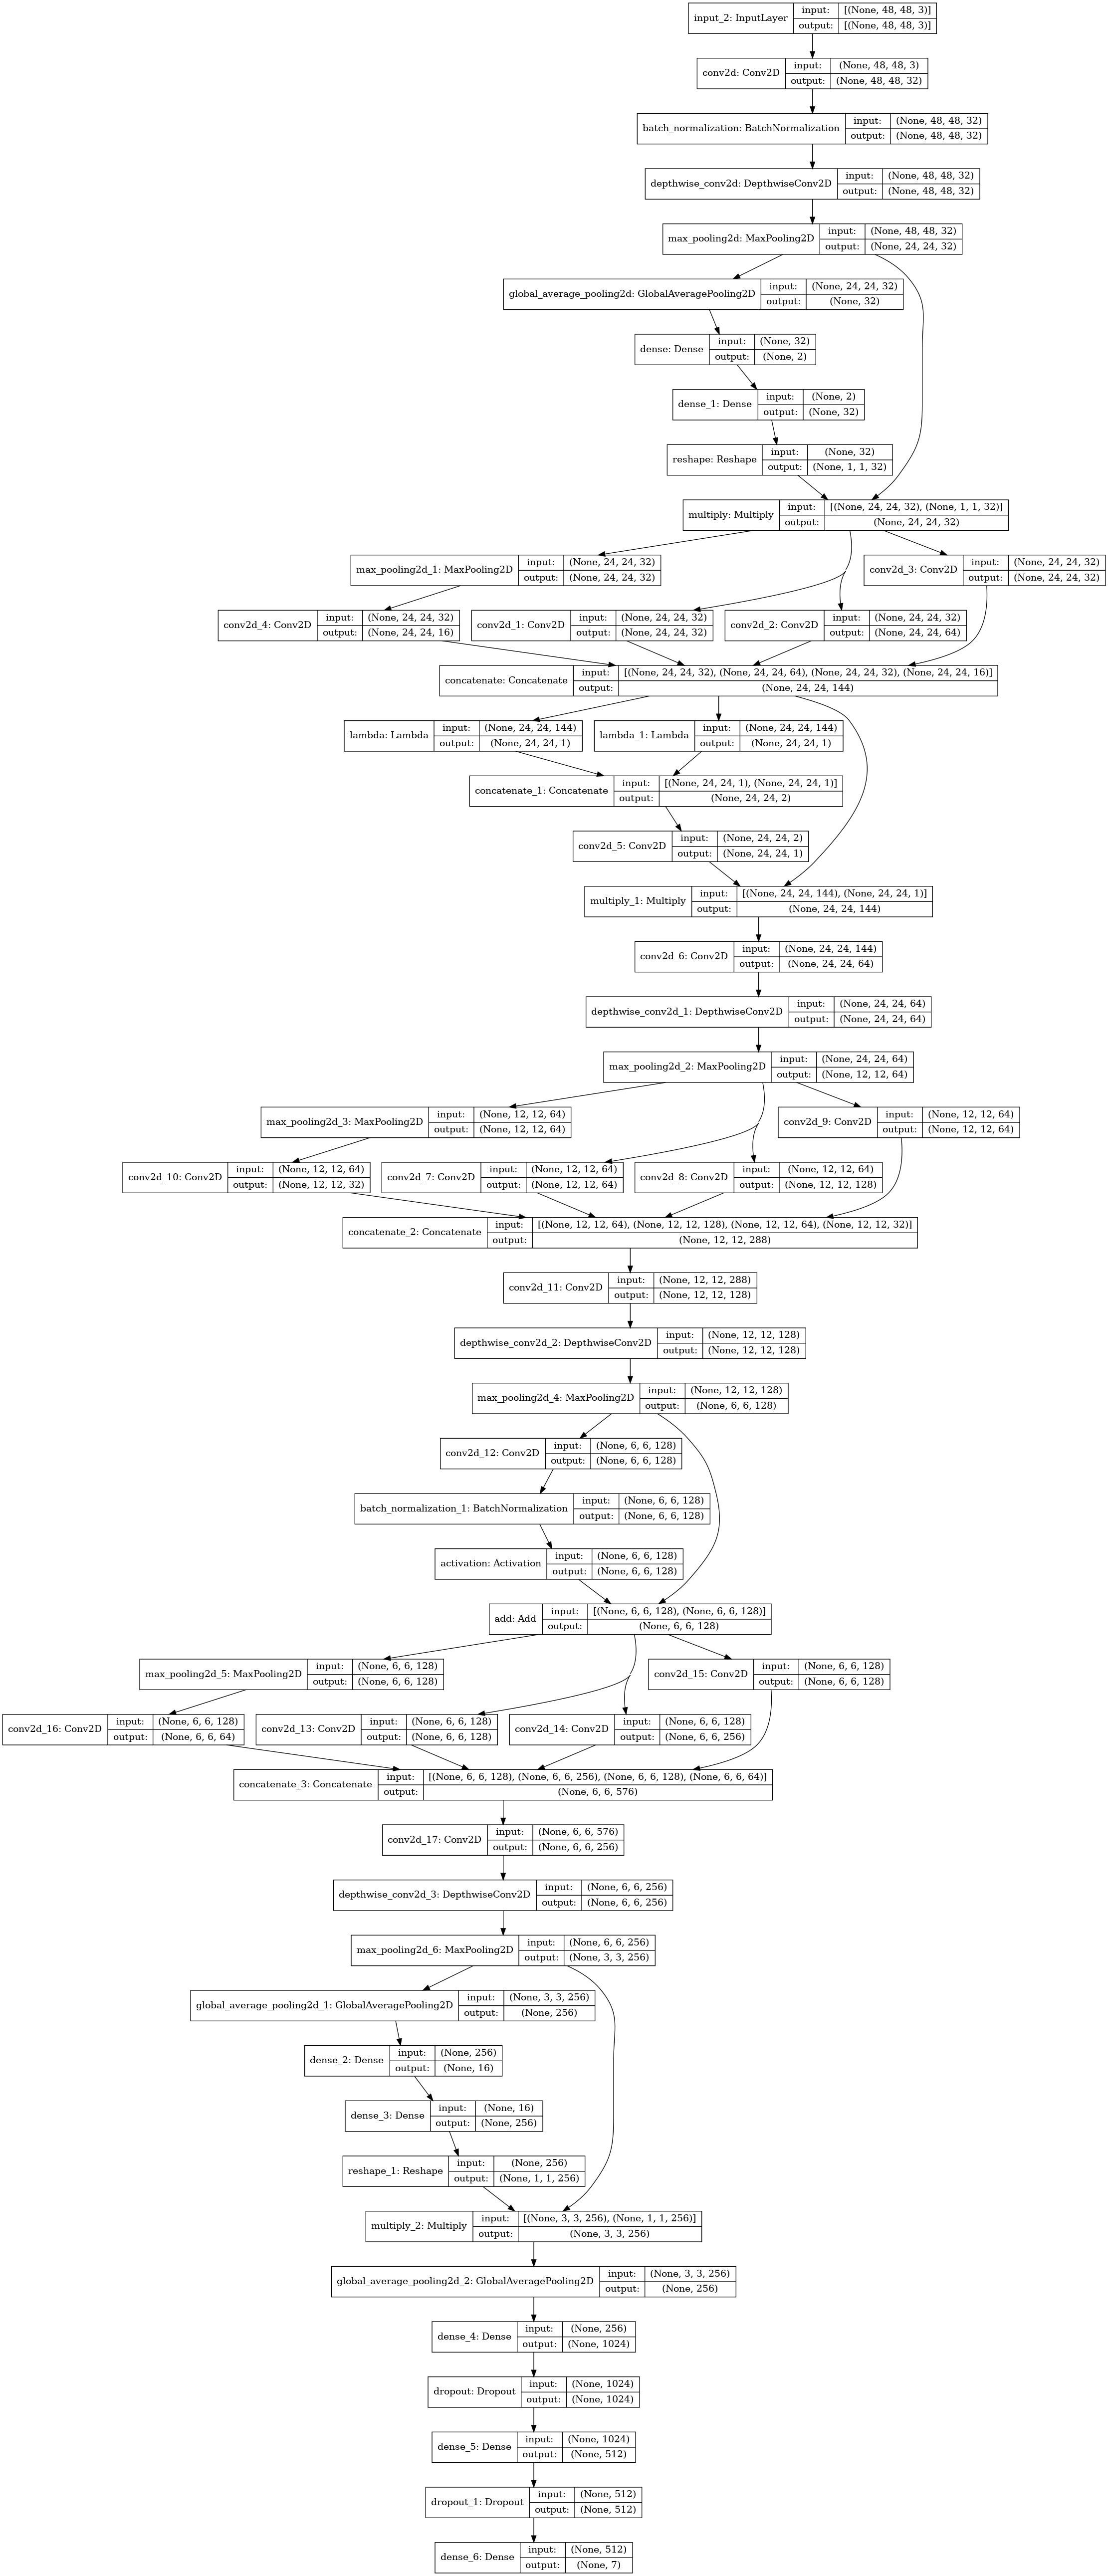

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, concatenate, DepthwiseConv2D, Add, Activation, Reshape, Multiply, AveragePooling2D, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Squeeze and Excitation block
def squeeze_excite_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape(se_shape)(se)
    return Multiply()([input_tensor, se])

# Spatial Attention block
def spatial_attention(input_tensor):
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(input_tensor)
    concat = concatenate([avg_pool, max_pool], axis=-1)
    attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    return Multiply()([input_tensor, attention])

# Inception-like block
def inception_block(input_tensor, filters):
    f1, f3, f5, fpool = filters

    conv1 = Conv2D(f1, kernel_size=1, padding='same', activation='relu')(input_tensor)

    conv3 = Conv2D(f3, kernel_size=3, padding='same', activation='relu')(input_tensor)

    conv5 = Conv2D(f5, kernel_size=5, padding='same', activation='relu')(input_tensor)

    pool = MaxPooling2D(pool_size=3, strides=1, padding='same')(input_tensor)
    pool = Conv2D(fpool, kernel_size=1, padding='same', activation='relu')(pool)

    output = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return output

# Inputs
input_layer = Input((48, 48, 3))

# Initial Conv Layer
x = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)

# Adding Depthwise Convolution
x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

# Squeeze and Excitation
x = squeeze_excite_block(x)

# First Inception Block
x = inception_block(x, [32, 64, 32, 16])

# Spatial Attention
x = spatial_attention(x)

x = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

# Second Inception Block
x = inception_block(x, [64, 128, 64, 32])

x = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

# Residual Block
residual = Conv2D(128, kernel_size=1, strides=1, padding='same')(x)
residual = BatchNormalization()(residual)
residual = Activation('relu')(residual)

x = Add()([x, residual])

# Third Inception Block
x = inception_block(x, [128, 256, 128, 64])

x = Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

# Squeeze and Excitation
x = squeeze_excite_block(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully connected layers with Dropout
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

output_layer = Dense(7, activation='softmax')(x)

# Model
model = Model(inputs=input_layer, outputs=output_layer)

# Plot model to visualize architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model_complex.png', show_shapes=True)
Image("model_complex.png")


**Training and Saving the Model**

In [10]:
input_shape=(48,48,3)

#model = Sequential()
#model.add(model)
IMAGE_SIZE=(48,48)
from keras.preprocessing import image
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}
from keras.callbacks import Callback
import cv2

class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        #img = cv2.imread("/kaggle/input/fer2013/test/surprise/PrivateTest_10089743.jpg")
        #img = cv2.resize(img ,IMAGE_SIZE)
        img = image.load_img("/kaggle/input/ckplus/CK+48/anger/S010_004_00000017.png",target_size = (48,48),color_mode = "grayscale")
        img = np.array(img)
        

        #img = img / 255
        #img = img[np.newaxis, :, :, :]
        #pred=model.predict(img)
        img1 = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
        img2 = img1.reshape(1,48,48,3)
        result = model.predict(img2)
        result = list(result[0])
        img_index = result.index(max(result))
        label=label_dict[img_index]
        

        exp = GradCAM()
        cam = exp.explain(
            validation_data=(img2, result), 
            class_index=1,
            layer_name='Final_Layer', 
            model=self.model
            )

        plt.figure(figsize=(5,2))
        plt.subplot(1,2,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')

        plt.subplot(1,2,2)
        plt.title('GradCAM')
        plt.imshow(cam)
        plt.tight_layout()
        plt.show()
        print("***************************Predicted label: ",label)

epochs = 25



learning_rate = 1e-3
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("model_weights.h5", monitor="val_accuracy", save_weights_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.1, patience = 2, min_lr=0.00001, model='auto')

callbacks = [ModelCheckpoint('model.hdf5',monitor="val_accuracy", verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1, min_lr=1e-6),
            #ShowProgress(),
            EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=100)]

history = hist = model.fit(X_train, y_train, batch_size=7, epochs=epochs, verbose=1, validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/25
119/119 [==============================] - 13s 17ms/step - loss: 1.8446 - accuracy: 0.2437 - val_loss: 1.8839 - val_accuracy: 0.2230

Epoch 00001: val_accuracy improved from -inf to 0.22297, saving model to model.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
119/119 [==============================] - 1s 12ms/step - loss: 1.6201 - accuracy: 0.3409 - val_loss: 1.9883 - val_accuracy: 0.1486

Epoch 00002: val_accuracy did not improve from 0.22297
Epoch 3/25
119/119 [==============================] - 2s 13ms/step - loss: 1.2865 - accuracy: 0.4682 - val_loss: 2.0373 - val_accuracy: 0.1622

Epoch 00003: val_accuracy did not improve from 0.22297
Epoch 4/25
119/119 [==============================] - 1s 13ms/step - loss: 1.0290 - accuracy: 0.5714 - val_loss: 1.8159 - val_accuracy: 0.2365

Epoch 00004: val_accuracy improved from 0.22297 to 0.23649, saving model to model.hdf5
Epoch 5/25
119/119 [==============================] - 1s 13ms/step - loss: 0.7743 - accuracy: 0.6975 - val_loss: 0.7290 - val_accuracy: 0.7297

Epoch 00005: val_accuracy improved from 0.23649 to 0.72973, saving model to model.hdf5
Epoch 6/25
119/119 [==============================] - 1s 12ms/step - loss: 0.5684 - accuracy: 0.7851 - val_loss: 0.5488 - val_accuracy: 0.79

Test Loss: 0.17978648841381073
Test accuracy: 0.9662162065505981
(1, 48, 48, 3)
[[9.9999440e-01 2.1471163e-08 5.5945088e-06 1.3585950e-09 4.5558022e-22
  8.0982279e-17 5.0658024e-12]]
[[1. 0. 0. 0. 0. 0. 0.]]


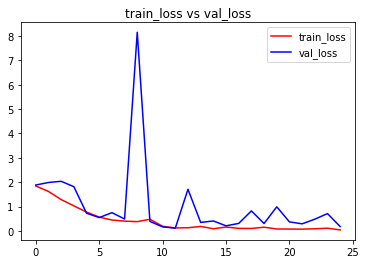

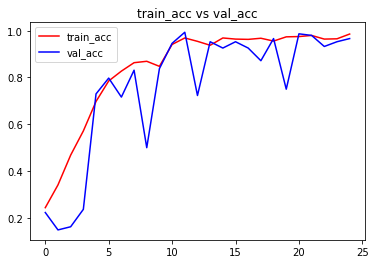

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [11]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()


score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
classes_x=np.argmax(model.predict(test_image),axis=1)
print(y_test[0:1])

res = np.argmax(model.predict(X_test[0:9]),axis=1)
plt.figure(figsize=(10, 10))

# show the plot
plt.show()

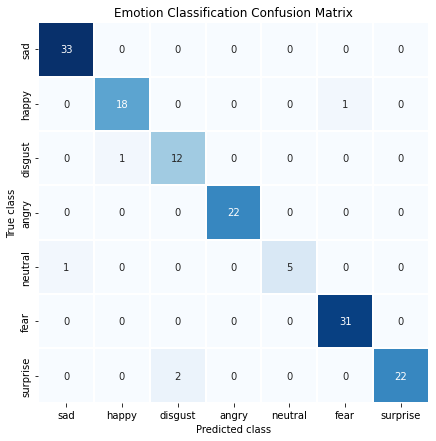

              precision    recall  f1-score   support

         sad       0.97      1.00      0.99        33
       happy       0.95      0.95      0.95        19
     disgust       0.86      0.92      0.89        13
       angry       1.00      1.00      1.00        22
     neutral       1.00      0.83      0.91         6
        fear       0.97      1.00      0.98        31
    surprise       1.00      0.92      0.96        24

    accuracy                           0.97       148
   macro avg       0.96      0.95      0.95       148
weighted avg       0.97      0.97      0.97       148



In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your model is a functional model
results = model.predict(X_test)

# Convert probabilities to class labels by selecting the index of the highest probability
predicted_classes = np.argmax(results, axis=1)

# Assuming y_test contains one-hot encoded labels, convert it to single labels
y_true = np.argmax(y_test, axis=1)

# Define your emotion labels in the desired order
label = ['sad', 'happy', 'disgust', 'angry', 'neutral', 'fear', 'surprise']

# Define the mapping of class indices to emotion labels
labels = {0: 'sad', 1: 'happy', 2: 'disgust', 3: 'angry', 4: 'neutral', 5: 'fear', 6: 'surprise'}

# Calculate the confusion matrix
cm = confusion_matrix(y_true, predicted_classes)

# Transform to DataFrame for easier plotting
cm_df = pd.DataFrame(cm, index=label, columns=label)

# Create a heatmap with a white-blue color palette ('Blues')
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', cbar=False, linewidth=2, fmt='d')
plt.title('Emotion Classification Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


from sklearn.metrics import classification_report

# Assuming you have 'y_true' (true labels) and 'predicted_classes' (predicted labels)
# 'target_names' is a list of class names in the same order as your labels
target_names = ['sad', 'happy', 'disgust', 'angry', 'neutral', 'fear', 'surprise']

# Generate the classification report
report = classification_report(y_true, predicted_classes, target_names=target_names)

# Print the classification report
print(report)


In [14]:
# Saving the model
model.save('emotion_detection_on_face_Latest.h5')  # Save the model in HDF5 format


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('emotion_detection_on_face_Latest.h5')


**Code to Predict Emotions from a different dataset**

In [ ]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define the emotion labels (assuming you have these mapped in the same order as in the model training)
emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load your trained model (replace 'your_model.h5' with the path to your saved model)
model = load_model('/kaggle/working/best_model.h5')

# Path to the folder containing images
image_folder = '/kaggle/input/newdataset'

# Check if folder exists
if not os.path.exists(image_folder):
    print(f"Error: The folder '{image_folder}' does not exist.")
else:
    # Loop through all files in the folder
    for image_name in os.listdir(image_folder):
        # Get the full path of the image
        image_path = os.path.join(image_folder, image_name)

        # Check if it's an image file (you can filter by extension here, if needed)
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):

            # Load the image
            img = cv2.imread(image_path)

            # Check if image was loaded correctly
            if img is None:
                print(f"Error: Could not load image {image_name}. Skipping.")
                continue

            # Convert the image from BGR (OpenCV default) to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize the image to the input size required by the model (e.g., 48x48)
            img_resized = cv2.resize(img_rgb, (48, 48))

            # Normalize the image data (scaling to 0-1 range)
            img_normalized = img_resized / 255.0

            # Reshape the image to match the input shape (e.g., (1, 48, 48, 3) for a single RGB image)
            img_input = np.reshape(img_normalized, (1, 48, 48, 3))

            # Make the emotion prediction using the trained model
            predicted_class = model.predict(img_input)

            # Get the index of the maximum probability
            emotion_index = np.argmax(predicted_class)

            # Get the predicted emotion label
            predicted_emotion = emotion_labels[emotion_index]

            # Print the predicted emotion for this image
            print(f"Image: {image_name} - Predicted Emotion: {predicted_emotion}")

            # Optionally, display the image with the predicted emotion label
            plt.imshow(img_rgb)
            plt.title(f'Predicted Emotion: {predicted_emotion}')
            plt.axis('off')
            plt.show()


In [ ]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define the emotion labels (assuming you have these mapped in the same order as in the model training)
emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load your trained model (replace 'your_model.h5' with the path to your saved model)
model = load_model('/kaggle/working/emotion_detection_on_face.h5')

# Path to the folder containing images
image_folder = '/kaggle/input/newdataset'

# Check if folder exists
if not os.path.exists(image_folder):
    print(f"Error: The folder '{image_folder}' does not exist.")
else:
    # Loop through all files in the folder
    for image_name in os.listdir(image_folder):
        # Get the full path of the image
        image_path = os.path.join(image_folder, image_name)

        # Check if it's an image file (you can filter by extension here, if needed)
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):

            # Load the image
            img = cv2.imread(image_path)

            # Check if image was loaded correctly
            if img is None:
                print(f"Error: Could not load image {image_name}. Skipping.")
                continue

            # Convert the image from BGR (OpenCV default) to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize the image to the input size required by the model (e.g., 48x48)
            img_resized = cv2.resize(img_rgb, (48, 48))

            # Normalize the image data (scaling to 0-1 range)
            img_normalized = img_resized / 255.0

            # Reshape the image to match the input shape (e.g., (1, 48, 48, 3) for a single RGB image)
            img_input = np.reshape(img_normalized, (1, 48, 48, 3))

            # Make the emotion prediction using the trained model
            predicted_class = model.predict(img_input)

            # Get the index of the maximum probability
            emotion_index = np.argmax(predicted_class)

            # Get the predicted emotion label
            predicted_emotion = emotion_labels[emotion_index]

            # Print the predicted emotion for this image
            print(f"Image: {image_name} - Predicted Emotion: {predicted_emotion}")

            # Optionally, display the image with the predicted emotion label
            plt.imshow(img_rgb)
            plt.title(f'Predicted Emotion: {predicted_emotion}')
            plt.axis('off')
            plt.show()
